Benjamin Hobson 94708385

(1) Data Description:

players.csv --> The players.csv data set has 196 observations, each recording a player with some basic information about that player. There are 7 columns, each representing a different variable. 
- experience: this variable is of type "chr" and it represents a categorical variable. It sorts players into different groups, like beginniner, amateur, normal, pro, and veteran.
- subscribe: this is a variable of type "lgl" which means it either is true or false. It records whether or not the player is subscribed to the game-related newsletter or not. This could be an interesting variable to observe and perhaps use as a class variable to predict, as it has two categories of either being true or false (perhaps variables like Age and experience can be used to predict the likelihood of someone being subscribed or not).
- hashedEmail: this variable is of type "chr" and provides the player's email (hashed so it is anonymous).
- player_hours: this variable is of type "dbl" and represents how many hours the player has played.
- name: "char" variable that records the name of the player.
- gender: categorical variable of type "chr" that defines gender. More than just male/female, there are a number of different options for everyone.
- age: records age in years, is of type "dbl".
Notes on the data: There are some missing values in the Age column, meaning I need to ensure I use na.rm = TRUE when I perform summary statistics on that variable. Besides that, this data is pretty tidy and unproblematic for manipulating it.

sessions.csv --> this dataframe has 1535 observations/rows and it has 5 variables/columns. From what I can reasonably infer, here is a basic description of each column: 
- hashedEmail: this is an identifier essentially, it's of type "chr" and it is an encrypted version of the users email who recorded the session.
- start_time: this is a varible of type "chr" this gives the exact minute (with the day, year and month attached) of when a player started a session on the server.
- end_time: also a variable of type "chr". Similar to start_time this gives the exact minute (with the day, year and month attached) of when a player ended a session on the server.
- original_start_time and original_end_time (both of type dbl): it seems like these columns display the time since another certain time (some year) in seconds or some small increment. That would explain why the values are so large. I think it is worth seeing the values printed out, to determine their usability in comparison to the other two time variables. 

Notes on the data: One idea that popped into my head after looking through the data couple times is that it might be useful to use mutate to create a new column using the data from the variables start_time and end_time to get the "play_time" column that subtracts the two times to just quickly see how long the player played for. It would make summary statistics on play time much simpler. This would require some work however to turn the "chr" variable into a date format. 



(2) Questions: 
My question of interest: using the players.csv data set, can a player’s age and hours played predict whether they subscribe to the game’s newsletter? This question is interesting to me because if I was trying to boost the amount of subscribers to the newsletter, I would want to know which type of players to target in my advertising efforts. For instance, if a younger age was more receptive to joining the newsletter, I would be more inclined to use social media to increase subscribership. To wrangle this data I will need to account for missing values in the Age column and I will need to standardize my data before I do any predictions to avoid having age or playing time being overpowering in the prediction. It might also be useful to refactor the lgl subscriber variable into a factor variable (as the thing we are trying to predict). This way, after making sure those are taken care of we can use K nearest neighbors voting to attempt to accurately predict whether someone is a subscriber or not. 






(3) Exploratory data analysis and visualization: 

In [15]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
##source('cleanup.R')

In [16]:
players <- read_csv("data/players.csv")
players

sessions <- read_csv("data/sessions.csv")


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
players_recode <- players |>
  mutate(subscribe = as_factor(subscribe)) |>
  mutate(subscribe = fct_recode(subscribe, "Subscribed" = "TRUE", "Not subscribed" = "FALSE"))
players_recode

#Now we have turned subscribe from lgl to fct, making it a factor variable 
#as well as improving readability allowing us to use it as the variable we are trying to predict 

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,Subscribed,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,Subscribed,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,Not subscribed,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,Not subscribed,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,Not subscribed,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,Subscribed,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [18]:
#Summary statistics on the quantitative variables in the player dataframe: 

players_mean <- players |>
select(played_hours, Age) |>
map_df(mean, na.rm = TRUE)

players_mean

played_hours,Age
<dbl>,<dbl>
5.845918,20.52062


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


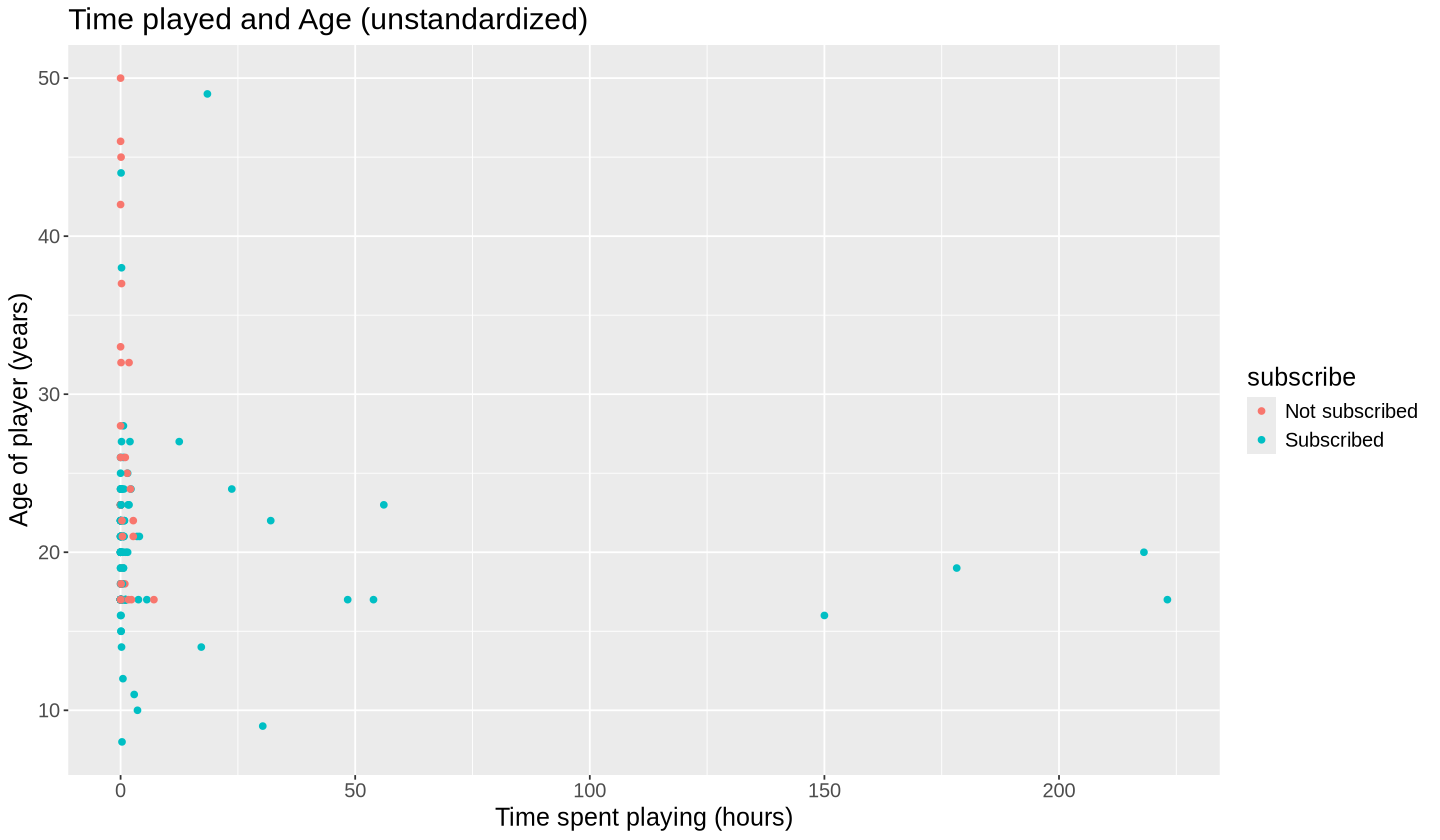

In [19]:
#Data visualizations to understand the data better 
options(repr.plot.width=12, repr.plot.height=7)
players_plot <- players_recode |> 
ggplot(aes(x = played_hours, y = Age, color = subscribe)) + 
geom_point() +
labs(x = "Time spent playing (hours)", y = "Age of player (years)", title = "Time played and Age (unstandardized)") + 
theme(text = element_text(size = 15))
players_plot

Based on this first plot, it does seem like we can use thes variables to predict because I do observe a relationship between the variables and we can see that as we increase the time spent playing, it seems to increase our chances of subscribership. The data is unstandardized, but when we perform our actual predictive analysis the relationships will be more clear. It seems like right now the main insight is how time spent playing seems to greatly increase the odds of someone subscribing. The next plot I will create will be to understand the basic distribution of our played_hours variable to see where most players fall:

Warning message:
“Removed 6 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


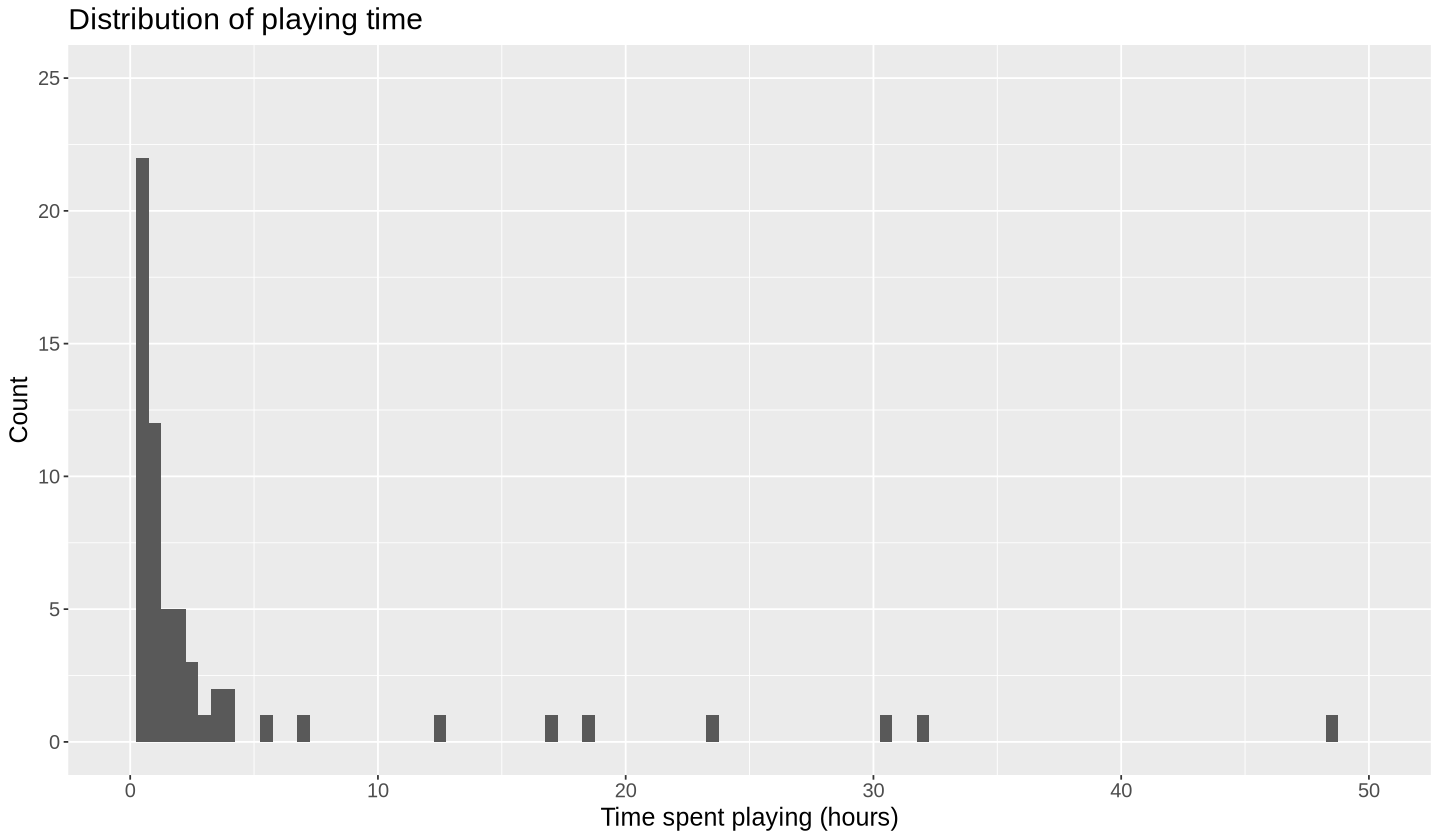

In [29]:

players_histogram <- ggplot(players_recode, aes(x = played_hours)) + 
geom_histogram(binwidth = 0.5) +
labs(x = "Time spent playing (hours)", y = "Count", title = "Distribution of playing time") + 
theme(text = element_text(size = 15))
       
players_histogram + scale_x_continuous(limits = c(0, 50)) + scale_y_continuous(limits = c(0, 25))

From this visualization (focusing on less extreme values where most of our data is centered around) we are able to tell that a huge proportion of the players have played less than 5 hours, and a massive amount of them have played 0-1 hours, which means that they are likely joining the server and not playing much. This may be useful because perhaps by targeting those groups, by getting the newsletters it would increase the amount of time they play.  

(4) Methods and Plan: 
I plan on using a K nearest neighbors classification algorithm to understand the relationship between how the Age and played_hours variable can help predict the subscribe variable. One limitation revealed by the visualizations above is that it seems like a lot of users are close to 0 playing time, which means our data will not be distributed in a very reliable way for predictions close to 0 played_hours. First I will create a recipe using the chosen predictor variables and the target variable. I would then use scale() to ensure my data has been standardized and each predictor variable has the same weight in distance calculations. I would divide the data into a training set and a test set, with a 0.75 to 0.25 split. I will not create a separate validation set but will use cross-validation (5 fold) on the training set to determine the best value for K. Then I will apply the algorithm, making predictions on the test set where I can then evaluate performance. Putting all of these together, I will have a strong foundation in how predictive these variables are, and with the analysis complete inferences can be made about strategy in terms of how to get more subscribers to the newsletter. 

In [ ]:


options(repr.plot.height = 5, repr.plot.width = 6)

data_recipe <- recipe(y ~ ., data = training_set)
data_vfold <- vfold_cv(training_set, v = 5, strata = y)

kvalues_tibble <- tibble(neighbors = c(2, 3, 4, 5, 6))

knn_results <- workflow() |> 
    add_recipe(data_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = data_vfold, grid = kvalues_tibble)

data_metrics <- collect_metrics(knn_results)

accuracies <- data_metrics |>
filter(.metric == "accuracy") |>
mutate(neighbors = as.numeric(neighbors), mean = as.numeric(mean)) |>
drop_na()


cross_val_plot <- accuracies |>
ggplot(aes(x = neighbors, y = mean)) + 
geom_point() +
geom_line() + 
labs(x = "K number of neighbors", y = "Accuracy of Model Estimate") + 
theme(text = element_text(size = 12))

subscriber_recipe <- recipe(subscrube ~ Age + played_hours, data = players_recode) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())


subscriber_scaled <- subscriber_recipe |>  
                            prep() |> 
                            bake(players_recode)

subscriber_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
       set_engine("kknn") |>
       set_mode("classification")

subscriber_fit <- workflow() |>
          add_recipe(subscriber_recipe) |>
          add_model(subscriber_spec) |>
          fit(data = players_recode)



